# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
#!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    tagged_word=[]
    preprocessed_example=[]
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    #print(example)
    word_set =[] 
    for word in example:
        #print(word[0])
        word_set.append(word[0])
    word_set=posttagger.tag(word_set)
    #print(word_set)
    for word,word_tag in zip(example,word_set):
        tagged_word.append(word[0]+"@"+word_tag[1])
    #print(preprocessed_example)
    for word,new_word in zip(example,tagged_word):
        preprocessed_example.append((new_word,word[1]))
    #print(preprocessed_example)
    #preprocessed_example=posttagger.tag(word_set))
    #preprocessed_example = example 
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]
print(training_data[0])
#print(training_data[0])
#print(raw_training_data[0])

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [9]:
#####################################
#####################################
#####################################
# check the effect of pre-processing
#task 1 overhere 
#split by oder
split_size = 0.8
split_len = int(len(training_data) * split_size)
training_data_80 = training_data[0 : split_len]
test_data_20 = training_data[split_len : ]

print(len(training_data))
print(len(training_data_80))
print(len(test_data_20))

7816
6252
1564


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens , idx ):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    N = 1
    token = tokens[idx]
    feature_list = []
    Pos = "@"
    try:
        Pre = tokens[(idx-N):idx]
        Suf = tokens[(idx+1):(idx+N+1)]
    except:
            print("index err")
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    #####################################
    #####################################
    #####################################
    #compare features below for task 5

    # feature prelifx
    # if len(token) > 1:
    #    feature_list.append("PRE_" + token[:1])
    # if len(token) > 2:
    #     feature_list.append("PRE_" + token[:2])
    # if len(token) > 3:
    #     feature_list.append("PRE_" + token[:3])
     
    # # feature pre word & pre POS tag
    # if Pre:
    #     for pre in Pre:
    #         feature_list.append("Pre_Word_" + pre.split(Pos)[0])         
    #         feature_list.append("Pre_POS_" + pre.split(Pos)[1])

    # #feature sufflix

    # if len(token) > 1:
    #    feature_list.append("SUF_" + token[-1:])
    # if len(token) > 2:
    #     feature_list.append("SUF_" + token[-2:])
    # if len(token) > 3:
    #     feature_list.append("SUF_" + token[-3:])

    #feature suff word & wuff POS tag
    
    # if Suf:
    #     for suff in Suf:
    #         feature_list.append("SUF_Wod" + suff.split(Pos)[0])
    #         feature_list.append("SUF_Pos" + suff.split(Pos)[1])

    if Pos in token:
        word = token.split(Pos)
        # feature_list.append("POS_" + word[1])
        feature_list.append("WORD_" + word[0])
    else:
        feature_list.append("WORD_" + token)
    print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features,training_opt={"feature.minfreq":1})  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    #print(tags)
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
#example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
#print_tags(example)

In [14]:
# a novel, unseen example we've just made up
#print_tags("batman is the main character in batman begins")

In [15]:
# another example
#print_tags("the sound of music")

In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features,training_opt={"feature.minfreq":1})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data_20), "instances")
print(sum([len(sent) for sent in test_data_20]), "words")

1564 instances
31304 words


In [17]:
print("testing tagger...")
preds = []
y_test = []
sentence = ""
sentence_group = []
Lowest_precision_class=["I-Soundtrack", "B-Soundtrack", "I-Opinion", "B-Plot", "B-Opinion"] #task 2 class
Lowest_recall_class=["I-Soundtrack", "B-Soundtrack", "I-Opinion", "I-Character_Name", "B-Character_Name"] #task 3 class
for sent in test_data_20:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    #print(sent_preds)
    sent_true = [s[1] for s in sent]
    #print(sent_true[0])
    
    for tag_true,tag_preds in zip(sent_true,sent_preds):
        # if tag_preds in Lowest_precision_class:
        #     if tag_preds != tag_true:#FP
        if tag_true in Lowest_recall_class:      
            if  tag_true != tag_preds:#FN
                sentence = ""
                for i in sent:
                    sentence += i[0].split("@")[0] + " " #take off POS coming from task4
                sentence_group.append(sentence)
                break
    #print(sentence)
    preds.extend(sent_preds)
    y_test.extend(sent_true)
#####################################
#####################################
#####################################
#print answers to task2/3
for sent in sentence_group:
    print(sent)
#print(len(test_data_20))
#print(len(sentence_group))#how many wrong sentences
print("done")

testing tagger...
one of the most memorable scenes from this film involve a boy riding his bike through the sky 
orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some 
paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer 
penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama 
perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy 
peter jackson directed this smash hit starring jack black as a 1930 s film maker on a mission to make an unforgettable nature documentary who gets more than he bargained for 
rapunzel is having a bad hair day she s out of the tower and off to discover life in this 2010 animated feature 
red riding hood is training in the group of si

In [18]:
# Output the classification report (which you should save each time for comparing your models)
print("#####################################################")
print("task 4 with POS tag")
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'
))  # print out accurate macro score

#####################################################
task 4 with POS tag


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.92      0.89      0.90      1231
         B-Award       0.76      0.64      0.70        75
B-Character_Name       1.00      0.09      0.17       212
      B-Director       0.91      0.75      0.82       472
         B-Genre       0.91      0.82      0.87       805
       B-Opinion       0.60      0.29      0.39       160
        B-Origin       0.64      0.48      0.55       159
          B-Plot       0.53      0.51      0.52      1221
         B-Quote       0.75      0.25      0.38        24
  B-Relationship       0.86      0.50      0.64       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.92      0.90      0.91      1731
         I-Award       0.83      0.81      0.82       202
I-Character_Name       1.00      0.10      0.19       165
      I-Director       0.89      0.77      0.83       456
         I-Ge

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    print(labels)
    cm = confusion_matrix(y_test, preds)
    #cm = confusion_matrix(y_test, preds, labels) para erro
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

['I-Actor', 'B-Year', 'B-Director', 'B-Relationship', 'B-Opinion', 'O', 'B-Origin', 'B-Genre', 'I-Year', 'B-Award', 'I-Soundtrack', 'I-Director', 'B-Actor', 'I-Quote', 'B-Quote', 'I-Character_Name', 'B-Plot', 'I-Plot', 'I-Relationship', 'I-Award', 'B-Character_Name', 'I-Opinion', 'I-Genre', 'I-Origin', 'B-Soundtrack']


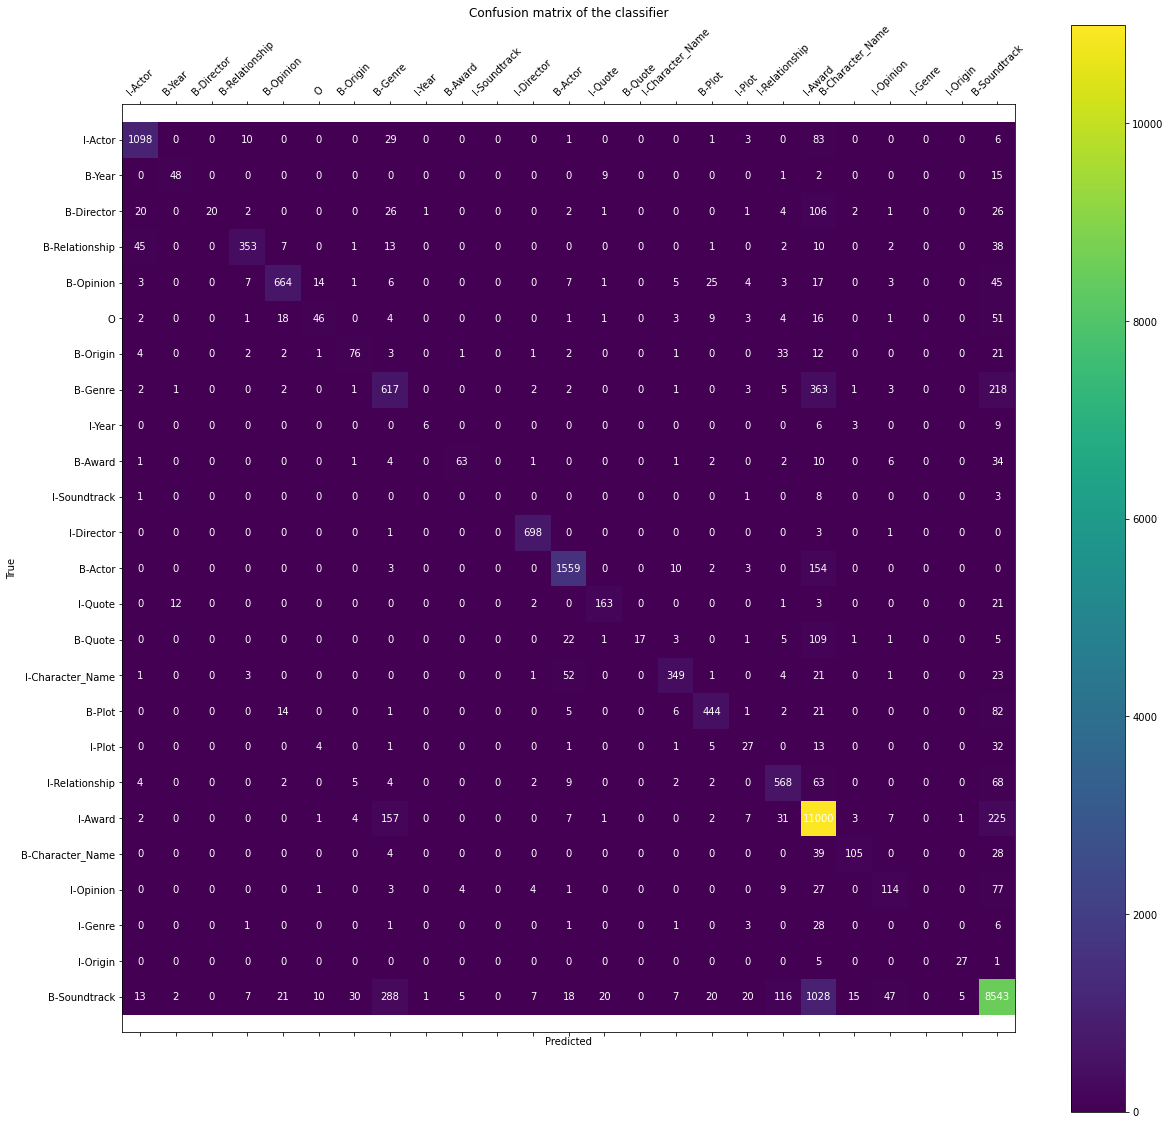

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [ ]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [ ]:
print_transition_weights(ct._tagger.info().transitions.items())

In [ ]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [ ]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [ ]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(type(words))
print(type(posttagger.tag(words)))
print(posttagger.tag(words))

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [ ]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":3})  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

In [ ]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))